# Peter and the Wolf: Realistic Environment

In our scenario, Peter could move around almost endlessly without feeling tired or hungry. In a more realistic world, he would need to take breaks to rest and eat to sustain himself. Let's make our world more lifelike by introducing the following rules:

1. Moving from one place to another causes Peter to lose **energy** and accumulate **fatigue**.
2. Peter can restore energy by eating apples.
3. Peter can reduce fatigue by resting under a tree or on the grass (i.e., stepping into a board location with a tree or grass - green field).
4. Peter must locate and defeat the wolf.
5. To defeat the wolf, Peter needs to have specific levels of energy and fatigue; otherwise, he will lose the fight.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

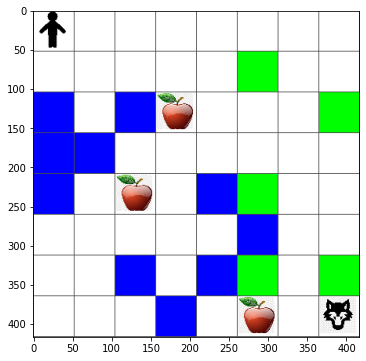

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Defining state

In our new game rules, we need to track energy and fatigue at each board state. Therefore, we will create an object `state` that will hold all the necessary information about the current problem state, including the state of the board, current energy and fatigue levels, and whether we can defeat the wolf in the terminal state:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Let's try to solve the problem using random walk and see if we succeed:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Reward Function

The reward function is a critical component in reinforcement learning. It defines the goal of the agent by assigning a numerical reward for each action taken in a given state. The agent's objective is to maximize the cumulative reward over time.

### Key Considerations

- **Clarity of Objectives**: The reward function should clearly reflect the desired outcome. If the reward is ambiguous or poorly defined, the agent may learn unintended behaviors.
- **Balance**: Avoid overly rewarding intermediate steps, as this might lead the agent to focus on those steps rather than the ultimate goal.
- **Scalability**: Ensure the reward function scales appropriately with the complexity of the task. A reward function that is too simple may not capture the nuances of the problem, while one that is too complex may hinder learning.

### Examples

#### Example 1: Simple Reward Function

In a navigation task, the agent receives a reward of +1 for reaching the goal and 0 otherwise.

```python
def reward_function(state, action):
    if state == goal_state:
        return 1
    else:
        return 0
```

#### Example 2: Penalizing Undesirable Actions

In a driving simulation, the agent is penalized for collisions and rewarded for staying on the road.

```python
def reward_function(state, action):
    if state == collision_state:
        return -10
    elif state == off_road_state:
        return -5
    elif state == goal_state:
        return 10
    else:
        return 0
```

### Common Pitfalls

- **Sparse Rewards**: If rewards are too infrequent, the agent may struggle to learn. Consider adding intermediate rewards to guide the agent.
- **Reward Hacking**: The agent might exploit loopholes in the reward function to achieve high rewards without fulfilling the intended objective. Regularly evaluate the agent's behavior to ensure alignment with the goal.
- **Overfitting to the Reward Function**: The agent might over-optimize for the specific reward function, leading to poor generalization in slightly different scenarios.

### Best Practices

- Test the reward function in a variety of scenarios to ensure it promotes the desired behavior.
- Use domain knowledge to design a reward function that aligns with the task's objectives.
- Iterate and refine the reward function based on the agent's performance and observed behavior.

By carefully designing the reward function, you can guide the agent to learn effective and efficient strategies for solving the task at hand.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning algorithm

The learning algorithm itself remains almost the same; we simply use `state` instead of just the board position.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

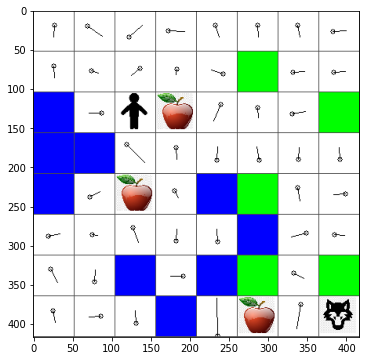

In [11]:
m.plot(Q)

## Results

Let's see if we managed to train Peter to fight the wolf successfully!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


We now see much fewer cases of drowning, but Peter is still not always able to kill the wolf. Try to experiment and see if you can improve this result by playing with hyperparameters.


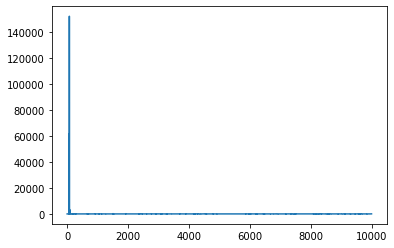

In [13]:
plt.plot(lpath)


---

**Disclaimer**:  
This document has been translated using the AI translation service [Co-op Translator](https://github.com/Azure/co-op-translator). While we strive for accuracy, please note that automated translations may contain errors or inaccuracies. The original document in its native language should be regarded as the authoritative source. For critical information, professional human translation is recommended. We are not responsible for any misunderstandings or misinterpretations resulting from the use of this translation.
